Train: (6261, 10000), Val: (3084, 10000), Test: (4005, 10000)
Blending Accuracy: 82.497


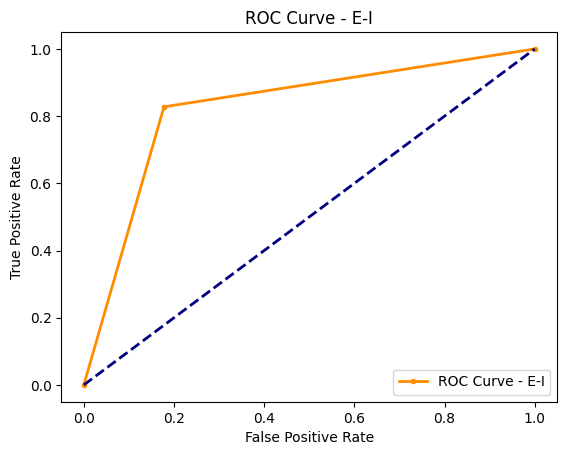

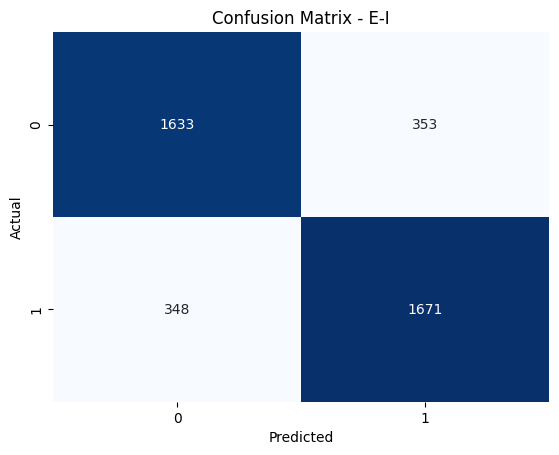

C:\Users\devra\AppData\Local\Temp\ipykernel_20088\1787636432.py:144: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  evaluation_df = pd.concat([evaluation_df, pd.DataFrame({


D:\\devra\\Downloads\\blending_results\\BlendingClassifier_E-I.sav
Train: (7012, 10000), Val: (3455, 10000), Test: (4487, 10000)
Blending Accuracy: 89.169


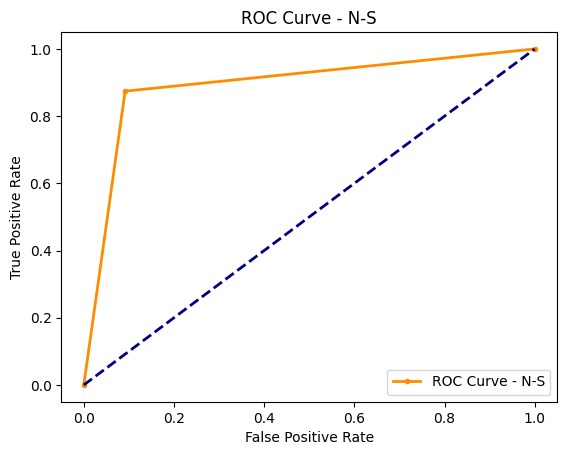

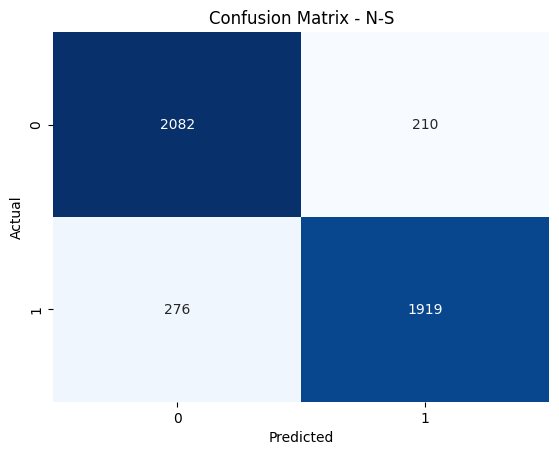

D:\\devra\\Downloads\\blending_results\\BlendingClassifier_N-S.sav
Train: (4401, 10000), Val: (2169, 10000), Test: (2816, 10000)
Blending Accuracy: 81.357


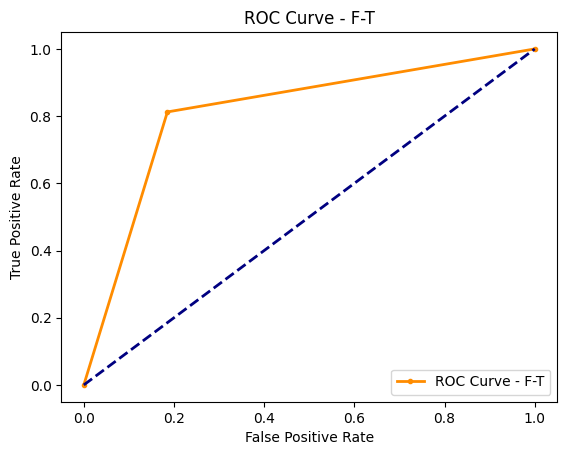

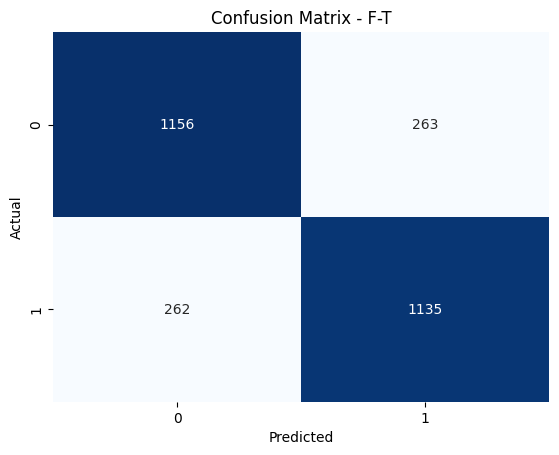

D:\\devra\\Downloads\\blending_results\\BlendingClassifier_F-T.sav
Train: (4915, 10000), Val: (2421, 10000), Test: (3144, 10000)
Blending Accuracy: 75.159


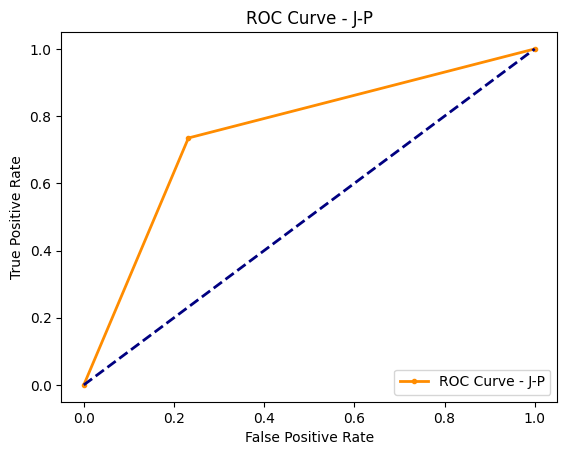

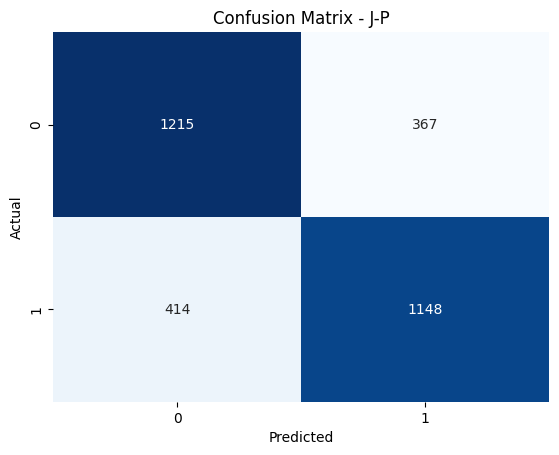

D:\\devra\\Downloads\\blending_results\\BlendingClassifier_J-P.sav
  Target  Accuracy  Precision    Recall  F1-Score   Roc-AUC
0    E-I  0.824969   0.825593  0.827637  0.826614  0.824947
1    N-S  0.891687   0.901362  0.874260  0.887604  0.891318
2    F-T  0.813565   0.811874  0.812455  0.812165  0.813557
3    J-P  0.751590   0.757756  0.734955  0.746181  0.751485


In [3]:
# blending ensemble for classification using soft voting
from numpy import hstack
import os
import pickle
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import roc_curve, confusion_matrix
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier

ROOT = r"C:\\Users\\devra\\Downloads\\Codes_PhD"
DATA_DIR = rf"{ROOT}\\dataset\\bvclassifier"
MBTI_RAW_CSV_PATH = os.path.join(DATA_DIR, "mbti_clean_biTri.csv")
MODEL = rf"{ROOT}\\models\\trained_ml_0603\\"
OUTPUT = r"D:\\devra\\Downloads\\blending_results\\"

data = pd.read_csv(MBTI_RAW_CSV_PATH)

training_data = data[["cleaned_post", "E-I", "N-S", "F-T", "J-P"]].copy()

def make_dummies(data, columns=["E-I", "N-S", "F-T", "J-P"]):
    for column in columns:
        temp_dummy = pd.get_dummies(data[column], prefix="type")
        data = data.join(temp_dummy)
    return data

training_data = make_dummies(training_data)

X = training_data[["cleaned_post"]]
y = training_data.drop(columns=["cleaned_post"])

oversample = RandomOverSampler(sampling_strategy=1, random_state=42)

vectorizer = TfidfVectorizer(max_features=10000, sublinear_tf=True, smooth_idf=True, norm='l2', min_df=2,
                             max_df=0.8, ngram_range=(1, 2), stop_words='english')
vectorizer.fit(X["cleaned_post"])
X_transformed = vectorizer.transform(X["cleaned_post"])

y_columns = ["E-I", "N-S", "F-T", "J-P"]
evaluation_df = pd.DataFrame(columns=["Target", "Accuracy", "Precision", "Recall", "F1-Score", "Roc-AUC"])

def get_models():
    models = list()
    models.append(('LogisticRegression', LogisticRegression(max_iter=1000, random_state=42)))
    models.append(('NaiveBayes', MultinomialNB(alpha=0.01)))
    models.append(('DecisionTree', DecisionTreeClassifier(max_depth=7)))
    models.append(('RandomForest', RandomForestClassifier(n_estimators=750)))
    models.append(('AdaBoost', AdaBoostClassifier()))
    models.append(('Xgboost', GradientBoostingClassifier()))
    return models

# fit the blending ensemble
def fit_ensemble(models, X_train, X_val, y_train, y_val):
# fit all models on the training set and predict on hold out set
    meta_X = list()
    for name, model in models:
    # fit in training set
        model.fit(X_train, y_train)
        # predict on hold out set
        yhat = model.predict_proba(X_val)
        # store predictions as input for blending
        meta_X.append(yhat)
        # create 2d array from predictions, each set is an input feature
        meta_X = hstack(meta_X)
        # define blending model
        blender = LogisticRegression()
        # fit on predictions from base models
        blender.fit(meta_X, y_val)
        return blender

# make a prediction with the blending ensemble
def predict_ensemble(models, blender, X_test):
    # make predictions with base models
    meta_X = list()
    for name, model in models:
        # predict with base model
        yhat = model.predict_proba(X_test)
        # store prediction
        meta_X.append(yhat)
        # create 2d array from predictions, each set is an input feature
        meta_X = hstack(meta_X)
        # predict
        return blender.predict(meta_X)

for target_name in y_columns:
    y_target = y[f"type_{target_name[0]}"]
    X_over, y_over = oversample.fit_resample(X_transformed, y_target)

    # X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.2, random_state=42)
    X_train_full, X_test, y_train_full, y_test = train_test_split(X_over, y_over, test_size=0.2, random_state=42)
    # split training set into train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.33, random_state=42)
    # summarize data split
    print('Train: %s, Val: %s, Test: %s' % (X_train.shape, X_val.shape, X_test.shape))
 
    # create the base models
    models = get_models()
    # train the blending ensemble
    blender = fit_ensemble(models, X_train, X_val, y_train, y_val)
    # make predictions on test set
    yhat = predict_ensemble(models, blender, X_test)
    # evaluate predictions
    score = metrics.accuracy_score(y_test, yhat)
    print('Blending Accuracy: %.3f' % (score*100))

    # Evaluate the ensemble
    accuracy = metrics.accuracy_score(y_test, yhat)
    precision = metrics.precision_score(y_test, yhat)
    recall = metrics.recall_score(y_test, yhat)
    f1_score = metrics.f1_score(y_test, yhat)
    roc_auc = metrics.roc_auc_score(y_test, yhat)

    # Plot ROC curve
    fpr, tpr, _ = metrics.roc_curve(y_test, yhat, drop_intermediate=False)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve - {target_name}', marker='.')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {target_name}')
    plt.legend(loc='lower right')
    plt.savefig(f'{OUTPUT}ROC_{target_name}_blending.png')
    plt.show()

    # Plot Confusion Matrix
    cm = confusion_matrix(y_test, yhat)
    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {target_name}')
    plt.savefig(f'{OUTPUT}ConfusionMatrix_{target_name}_blending.png')
    plt.show()

    # Update the evaluation_df DataFrame
    evaluation_df = pd.concat([evaluation_df, pd.DataFrame({
        "Target": [target_name],
        "Accuracy": [accuracy],
        "Precision": [precision],
        "Recall": [recall],
        "F1-Score": [f1_score],
        "Roc-AUC": [roc_auc]
    })], ignore_index=True)

    # Save the meta-model (blender)
    blending_filename = f'{OUTPUT}BlendingClassifier_{target_name}.sav'
    print(blending_filename)
    pickle.dump(blender, open(blending_filename, 'wb'))

# Save the evaluation_df to a CSV file
evaluation_df.to_csv(os.path.join(OUTPUT, 'evaluation_BlendingClassifier.csv'), index=False)
print(evaluation_df)

c:\Users\devra\anaconda3\envs\dev1\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Blending Accuracy: 88.502


C:\Users\devra\AppData\Local\Temp\ipykernel_6880\1319263059.py:120: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  fpr, tpr, _ = metrics.roc_curve(y_test.ravel(), yhat.ravel())


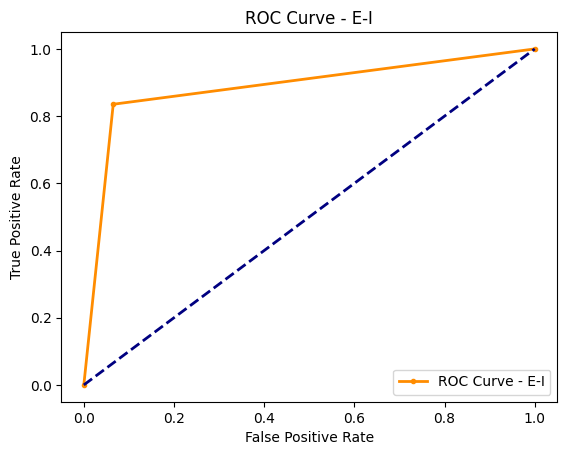

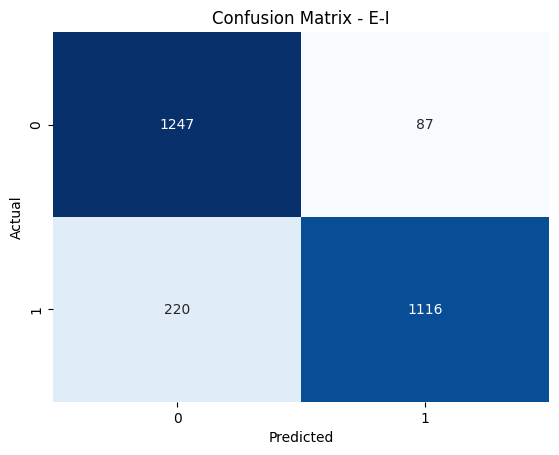

C:\Users\devra\AppData\Local\Temp\ipykernel_6880\1319263059.py:141: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  evaluation_df = pd.concat([evaluation_df, pd.DataFrame({


D:\\devra\\Downloads\\blending_results\\BlendingSMOTE_E-I.sav


c:\Users\devra\anaconda3\envs\dev1\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Blending Accuracy: 94.818


C:\Users\devra\AppData\Local\Temp\ipykernel_6880\1319263059.py:120: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  fpr, tpr, _ = metrics.roc_curve(y_test.ravel(), yhat.ravel())


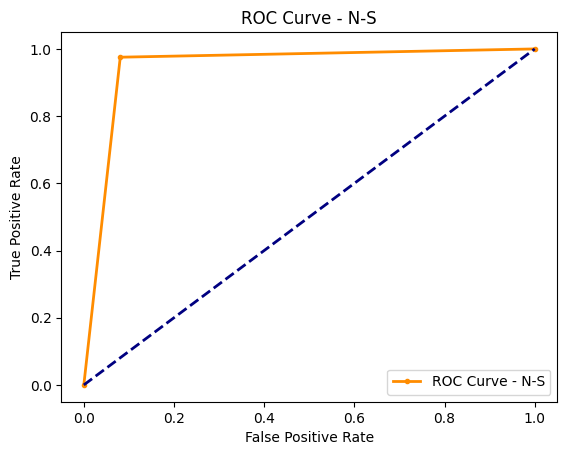

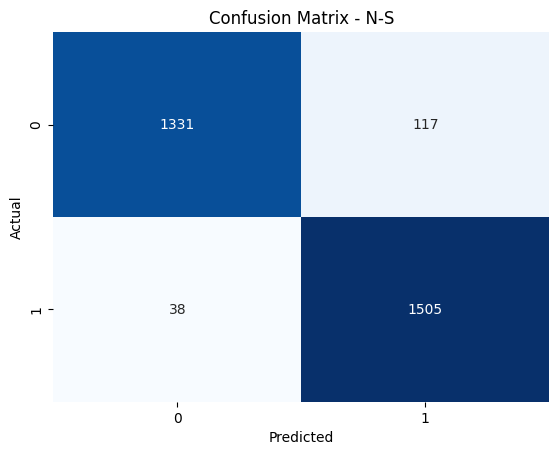

D:\\devra\\Downloads\\blending_results\\BlendingSMOTE_N-S.sav


c:\Users\devra\anaconda3\envs\dev1\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Blending Accuracy: 81.523


C:\Users\devra\AppData\Local\Temp\ipykernel_6880\1319263059.py:120: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  fpr, tpr, _ = metrics.roc_curve(y_test.ravel(), yhat.ravel())


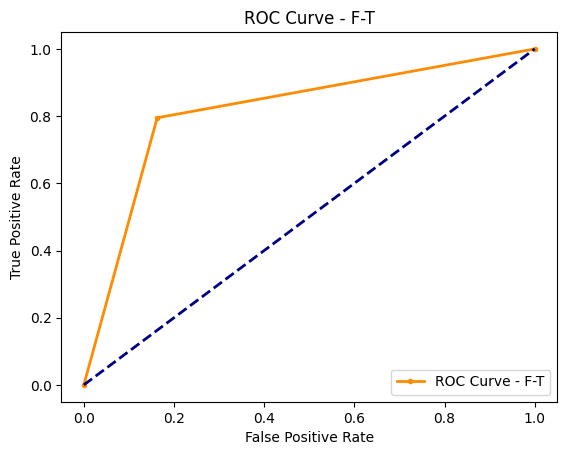

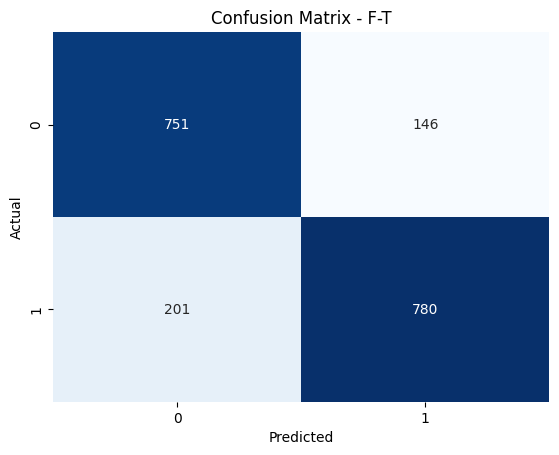

D:\\devra\\Downloads\\blending_results\\BlendingSMOTE_F-T.sav


c:\Users\devra\anaconda3\envs\dev1\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Blending Accuracy: 78.626


C:\Users\devra\AppData\Local\Temp\ipykernel_6880\1319263059.py:120: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  fpr, tpr, _ = metrics.roc_curve(y_test.ravel(), yhat.ravel())


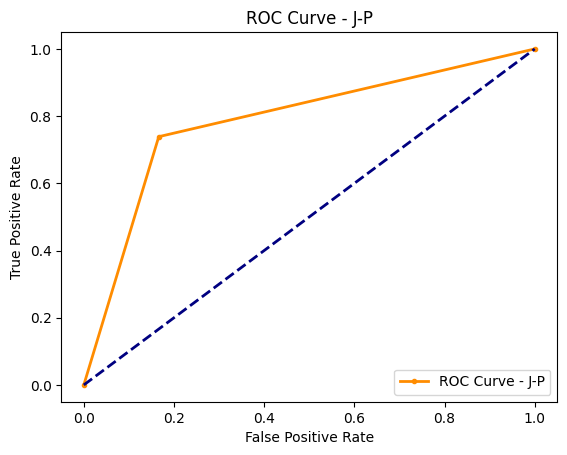

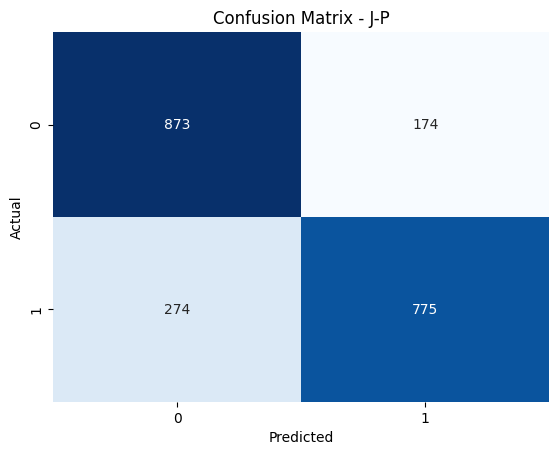

D:\\devra\\Downloads\\blending_results\\BlendingSMOTE_J-P.sav
  Target  Accuracy  Precision    Recall  F1-Score   Roc-AUC
0    E-I  0.885019   0.888887  0.885019  0.884737  0.885056
1    N-S  0.948178   0.949350  0.948178  0.948098  0.947286
2    F-T  0.815229   0.816795  0.815229  0.815313  0.816171
3    J-P  0.786260   0.788909  0.786260  0.785782  0.786305


In [5]:
from numpy import hstack
import os
import pickle
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, confusion_matrix
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from gensim.models import Word2Vec
from sklearn.preprocessing import MinMaxScaler

ROOT = r"C:\\Users\\devra\\Downloads\\Codes_PhD"
DATA_DIR = rf"{ROOT}\\dataset\\bvclassifier"
MBTI_RAW_CSV_PATH = os.path.join(DATA_DIR, "mbti_clean_biTri.csv")
MODEL = rf"{ROOT}\\models\\trained_ml_0603\\"
OUTPUT = r"D:\\devra\\Downloads\\blending_results\\"

data = pd.read_csv(MBTI_RAW_CSV_PATH)

training_data = data[["cleaned_post", "E-I", "N-S", "F-T", "J-P"]].copy()
def make_dummies(data, columns=["E-I", "N-S", "F-T", "J-P"]):
    for column in columns:
        temp_dummy = pd.get_dummies(data[column], prefix="type")
        data = data.join(temp_dummy)
    return data
training_data = make_dummies(training_data)

X = training_data[["cleaned_post"]]
y = training_data.drop(columns=["cleaned_post"])

smote = SMOTE()

vectorizer = TfidfVectorizer(max_features=10000)
vectorizer.fit(X["cleaned_post"])
X_transformed = vectorizer.transform(X["cleaned_post"])

y_columns = ["E-I", "N-S", "F-T", "J-P"]
evaluation_df = pd.DataFrame(columns=["Target", "Accuracy", "Precision", "Recall", "F1-Score", "Roc-AUC"])

def get_models():
    models = list()
    models.append(('LogisticRegression', LogisticRegression(max_iter=1000, random_state=42, multi_class='ovr')))
    models.append(('NaiveBayes', MultinomialNB(alpha=0.01)))
    models.append(('DecisionTree', DecisionTreeClassifier(max_depth=7)))
    models.append(('RandomForest', RandomForestClassifier(n_estimators=750)))
    models.append(('AdaBoost', AdaBoostClassifier()))
    models.append(('Xgboost', GradientBoostingClassifier()))
    return models

# fit the blending ensemble
def fit_ensemble(models, X_train, X_val, y_train, y_val):
    # fit all models on the training set and predict on the hold-out set
    meta_X = list()
    for name, model in models:
        # fit on the training set
        model.fit(X_train, y_train)
        # predict on the hold-out set
        yhat = model.predict_proba(X_val)
        # store predictions as input for blending
        meta_X.append(yhat)
    # create 2d array from predictions, each set is an input feature
    meta_X = hstack(meta_X)
    # define blending model
    blender = LogisticRegression(max_iter=1000, random_state=42, multi_class='ovr')
    # fit on predictions from base models
    blender.fit(meta_X, y_val)
    return blender

# make a prediction with the blending ensemble
def predict_ensemble(models, blender, X_test):
    # make predictions with base models
    meta_X = list()
    for name, model in models:
        # predict with base model
        yhat = model.predict_proba(X_test)
        # store prediction
        meta_X.append(yhat)
    # create 2d array from predictions, each set is an input feature
    meta_X = hstack(meta_X)
    # predict
    return blender.predict(meta_X)

for target_name in y_columns:
    y_target = y[f"type_{target_name[0]}"]
    
    X_over, y_over = smote.fit_resample(X_transformed, y_target)

    X_train_full, X_test, y_train_full, y_test = train_test_split(X_over, y_over, test_size=0.2, random_state=42)
    # split training set into train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.33, random_state=42)
    
    # create the base models
    models = get_models()
    # train the blending ensemble
    blender = fit_ensemble(models, X_train, X_val, y_train, y_val)
    # make predictions on test set
    yhat = predict_ensemble(models, blender, X_test)  
    # evaluate predictions
    score = metrics.accuracy_score(y_test, yhat)
    print('Blending Accuracy: %.3f' % (score * 100))

    # Evaluate the ensemble
    accuracy = metrics.accuracy_score(y_test, yhat)
    precision = metrics.precision_score(y_test, yhat, average='weighted')
    recall = metrics.recall_score(y_test, yhat, average='weighted')
    f1_score = metrics.f1_score(y_test, yhat, average='weighted')
    roc_auc = metrics.roc_auc_score(y_test, yhat, average='weighted', multi_class='ovr')

    # Plot ROC curve
    fpr, tpr, _ = metrics.roc_curve(y_test.ravel(), yhat.ravel())
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve - {target_name}', marker='.')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {target_name}')
    plt.legend(loc='lower right')
    plt.savefig(f'{OUTPUT}ROC_{target_name}_blending.png')
    plt.show()

    cm = confusion_matrix(y_test, yhat)
    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {target_name}')
    plt.savefig(f'{OUTPUT}ConfusionMatrix_{target_name}_blending.png')
    plt.show()

    # Update the evaluation_df DataFrame
    evaluation_df = pd.concat([evaluation_df, pd.DataFrame({
        "Target": [target_name],
        "Accuracy": [accuracy],
        "Precision": [precision],
        "Recall": [recall],
        "F1-Score": [f1_score],
        "Roc-AUC": [roc_auc]
    })], ignore_index=True)

    # Save the meta-model (blender)
    blending_filename = f'{OUTPUT}BlendingSMOTE_{target_name}.sav'
    print(blending_filename)
    pickle.dump(blender, open(blending_filename, 'wb'))

# Save the evaluation_df to a CSV file
evaluation_df.to_csv(os.path.join(OUTPUT, 'evaluation_BlendingSMOTE.csv'), index=False)
print(evaluation_df)